<a href="https://colab.research.google.com/github/gogowonji/Big-Data-Analysis/blob/main/20230411_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<< 국내 입국한 외국인의 통계 데이터 수집 >>
국가 코드를 입력하세요(중국:112/일본:130/미국"275) :112
데이터를 몇 년부터 수집할까요? : 2018
데이터를 몇 년까지 수집할까요? : 2018
http://openapi.tour.go.kr/openapi/service/EdrcntTourismStatsService/getEdrcntTourismStatsList?_type=json&serviceKey=54c7gqHFOZqfCZEFIs8az9Ro9O5dBpBujp6ThV779eI%2FW7GBWUPwXGPoXorpHSjf543vs8DLgAgr3M5XsFLfaw%3D%3D&YM=201801&NAT_CD=112&ED_CD=E
[2023-04-13 04:14:13.429877] Url Request Success
{
    "response": {
        "body": {
            "items": {
                "item": {
                    "ed": "방한외래관광객",
                    "edCd": "E",
                    "natCd": 112,
                    "natKorNm": "중  국",
                    "num": 305127,
                    "rnum": 1,
                    "ym": 201801
                }
            },
            "numOfRows": 10,
            "pageNo": 1,
            "totalCount": 1
        },
        "header": {
            "resultCode": "0000",
            "resultMsg": "OK"
        }
    }
}
[ 중국_201801 : 305127]
-------------

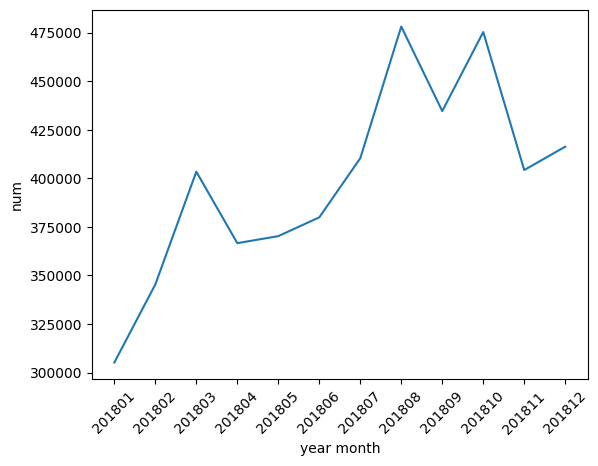

In [47]:
#  dataEND 2023년 입력시 2023 1,2월 데이터 밖에 없을 수도 있으니까

import os
import sys
import urllib.request
import datetime
import time
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import numpy as np

ServiceKey = "" # 인증키 조심

def getRequestUrl(url):
  req = urllib.request.Request(url)
  try:
    response = urllib.request.urlopen(req)
    if response.getcode() == 200:
      print("[%s] Url Request Success" % datetime.datetime.now())
      return response.read().decode('utf-8')
  except Exception as e:
    print(e)
    print("[%s] Error for URL : %s" % (datetime.datetime.now(), url))
    return None


def getTourismStatsItem(yyyymm, national_code, ed_cd):
  service_url = "http://openapi.tour.go.kr/openapi/service/EdrcntTourismStatsService/getEdrcntTourismStatsList"
  parameters = "?_type=json&serviceKey=" + ServiceKey
  parameters += "&YM=" + yyyymm
  parameters += "&NAT_CD=" + national_code
  parameters += "&ED_CD=" + ed_cd

  url = service_url + parameters
  print(url)
  retData = getRequestUrl(url)
  if (retData == None):
    return None
  else:
    return json.loads(retData)

def getTourismStatsService(nat_cd, ed_cd, nStartYear, nEndYear):
  jsonResult = []
  result = []
  natName = ''
  dataEND = '{0}{1}'.format(str(nEndYear), str(12))
  isDataEnd = 0
  ed = ''

  for year in range(nStartYear, nEndYear + 1):
    for month in range(1, 13):
      if(isDataEnd == 1): break #데이터 끝나면 끝내기
      # "{0}{1:0>2}".format(str(year),str(month-1)) -> 0번째 인덱스, 1번째 인덱스(두자리수 오른쪽정렬 해줘, 남은 자리는 0으로)
      yyyymm = "{0}{1:0>2}".format(str(year), str(month))
      jsonData = getTourismStatsItem(yyyymm, nat_cd, ed_cd)
      if (jsonData['response']['header']['resultMsg'] == 'OK'):
        # 데이터 없는 마지막 항목인 경우
        if jsonData['response']['body']['items'] == '':
          isDataEnd = 1 #데이터 끝 flag 설정
          dataEND = "{0}{1:0>2}".format(str(year),str(month-1))
          print("데이터 없음... \n 제공되는 통계 데이터는 %s년 %s월까지 입니다." %(str(year),str(month-1)))
          break
      #jsonData를 출력하여 확인
      print(json.dumps(jsonData, indent = 4, sort_keys = True, ensure_ascii = False))
      natName = jsonData['response']['body']['items']['item']['natKorNm']
      natName = natName.replace(' ','')
      num = jsonData['response']['body']['items']['item']['num']
      ed = jsonData['response']['body']['items']['item']['ed']
      print('[ %s_%s : %s]' %(natName, yyyymm, num))
      print('-------------------------------------------')
      jsonResult.append({'nat_name':natName, 'nat_cd':nat_cd, 'yyyymm':yyyymm, 'visit_cnt':num})
      result.append([natName, nat_cd, yyyymm, num])
  return (jsonResult, result, natName, ed, dataEND)

def drawPlot(fileName):
  f = open(fileName, encoding='euc-kr')
  data = csv.reader(f)
  next(data)
  data=list(data) # 읽어들일 데이터 리스트로 변환
  x = []
  y = []
  for line in data:
    x.append(line[2])
    y.append(int(line[3]))

  # 그래프 그리기
  plt.plot(x,y)
  plt.xlabel("year month")
  plt.ylabel("num")
  plt.xticks(rotation=45)
  plt.show()

def main():
  jsonResult = []
  result = []
  natName = ''

  print("<< 국내 입국한 외국인의 통계 데이터 수집 >>")
  nat_cd = input('국가 코드를 입력하세요(중국:112/일본:130/미국"275) :')
  nStartYear = int(input('데이터를 몇 년부터 수집할까요? : '))
  nEndYear = int(input('데이터를 몇 년까지 수집할까요? : '))
  ed_cd = "E" # 입국,출국코드

  # json, csv, 국가이름, 코드, 마지막데이터의연월
  jsonResult, result, natName, ed, dataEND = getTourismStatsService(nat_cd, ed_cd, nStartYear, nEndYear)
  if(natName == ''):
    print("데이터가 전달되지 않았습니다. 공공데이터포털의 서비스 상태를 확인하기 바랍니다.")
  else:
    with open('./%s+%s_%d_%s.json' % (natName, ed, nStartYear, dataEND), 'w', encoding ='utf8') as outfile:
      jsonFile = json.dumps(jsonResult, indent = 4, sort_keys = True, ensure_ascii = False)
      outfile.write(jsonFile)
      columns = ["입국자국가","국가코드", "입국연월", "입국자 수"]
      result_df = pd.DataFrame(result, columns = columns)
      csvName = './%s_%s_%d%s.csv' % (natName, ed, nStartYear, dataEND)
      result_df.to_csv(csvName, index=False, encoding='cp949')
      drawPlot(csvName)
      
if __name__ == '__main__':
  main()

